# **Import Libraries**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Import Helper Function**

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-20 18:40:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-20 18:40:45 (116 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **Load Important Functions**

In [4]:
from helper_functions import  create_tensorboard_callback , compare_historys , plot_loss_curves, pred_and_plot

# **Load Tensorflow Data**

In [5]:
import tensorflow_datasets as tfds

In [8]:
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

True


In [7]:
dataset_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [11]:
(train_data, test_data) , ds_info =tfds.load(name = 'food101',
          split = ['train', 'validation'],
          shuffle_files = True ,
          as_supervised = True,
          with_info = True
          )

# **Exploring and Becoming One With data**

In [12]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [14]:
class_names= ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [16]:
# Take One Sample Of Train data

train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape},
  Image DataType : {image.dtype},
  Target Class From 101 (Tensor Form) : {label},
  Class Name (Str Form) : {class_names[label.numpy()]}
  """)


  Image Shape : (384, 512, 3),
  Image DataType : <dtype: 'uint8'>,
  Target Class From 101 (Tensor Form) : 56,
  Class Name (Str Form) : huevos_rancheros
  


# **Plot Image From Tensorflow Datasets**

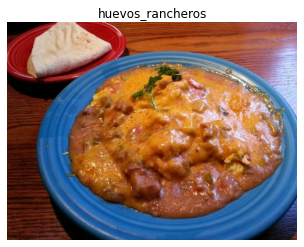

In [19]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# **Creating Preprocessing Function for Our Data**

In [30]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label 
  preprocessed_img = preprocess_img(image, label)[0]
  print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
  print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

# **Batching and Preparing Our Datasets**

In [31]:
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle Train data and Turn it into Batches and Prefetch it

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map Preprocess Function to Test Data

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# **Create Tensorboard Callbacks**

In [32]:
from helper_functions import create_tensorboard_callback

In [33]:
checkpoint_path = 'model_checkpoints/cp.ckpt'

In [34]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior = 'val_acc',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

# **Create Feature Extraction**

In [42]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create Base Model

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top= False)

base_model.trainable = False

# Create Functional Model

inputs = layers.Input(shape = input_shape, name= 'input_layer')

x = base_model(inputs, training=False)
x= layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype= tf.float32, name= 'softmax_float32')(x)
model = tf.keras.Model(inputs,outputs)


# Compile The Model

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetV2B0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientnetV2B0_101_classes_all_data_feature_extract/20220320-195454
Epoch 1/5
2368/2368 [==============================] - 173s 70ms/step - loss: 1.7451 - accuracy: 0.5762 - val_loss: 1.1464 - val_accuracy: 0.6984
Epoch 2/5
2368/2368 [==============================] - 177s 74ms/step - loss: 1.2110 - accuracy: 0.6866 - val_loss: 1.0380 - val_accuracy: 0.7262
Epoch 3/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.0639 - accuracy: 0.7226 - val_loss: 0.9886 - val_accuracy: 0.7338
Epoch 4/5
2368/2368 [==============================] - 169s 70ms/step - loss: 0.9688 - accuracy: 0.7463 - val_loss: 0.9797 - val_accuracy: 0.7394
Epoch 5/5
2368/2368 [==============================] - 167s 70ms/step - loss: 0.8985 - accuracy: 0.7637 - val_loss: 0.9603 - val_accuracy: 0.7383


# **Test or Evaluate The Model**

In [43]:
test_result = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 0.9610 - accuracy: 0.7370


# **Plot The Graph**

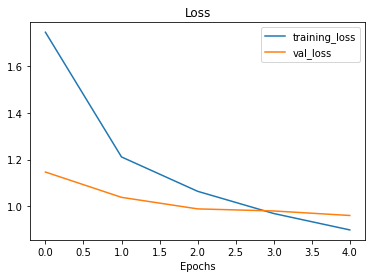

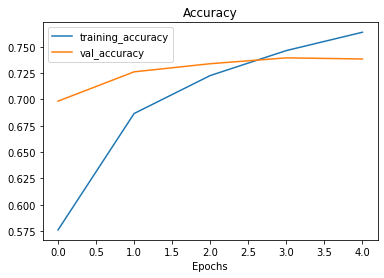

In [44]:
plot_loss_curves(history_101_food_classes_feature_extract)

# **Save The Model**

In [48]:
model.save('Model_Using_Feature_Extraction')

INFO:tensorflow:Assets written to: Model_Using_Feature_Extraction/assets


INFO:tensorflow:Assets written to: Model_Using_Feature_Extraction/assets


In [58]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_add False
20 block3a_expand_conv False
21 block3a_expand_bn False
22 block3a_expand_activation False
23 block3a_project_conv False
24 block3a_project_bn False
25 block3b_expand_conv False
26 block3b_expand_bn False
27 block3b_expand_activation False
28 block3b_project_conv False
29 block3b_project_bn False
30 block3b_add False
31 block4a_expand_conv False
32 block4a_expand_bn False
33 block4a_expand_activation False
34 block4a_dwconv2 False
35 block4a_bn False
36 block4a_activat

In [60]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model 
history_fine_10_percent_data_aug = model.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220320-202817
Epoch 5/10
2368/2368 [==============================] - 192s 77ms/step - loss: 0.7602 - accuracy: 0.7987 - val_loss: 0.8980 - val_accuracy: 0.7578
Epoch 6/10
2368/2368 [==============================] - 182s 76ms/step - loss: 0.6711 - accuracy: 0.8217 - val_loss: 0.8772 - val_accuracy: 0.7616
Epoch 7/10
2368/2368 [==============================] - 172s 72ms/step - loss: 0.5985 - accuracy: 0.8420 - val_loss: 0.8726 - val_accuracy: 0.7605
Epoch 8/10
2368/2368 [==============================] - 174s 73ms/step - loss: 0.5352 - accuracy: 0.8599 - val_loss: 0.8858 - val_accuracy: 0.7640
Epoch 9/10
2368/2368 [==============================] - 174s 73ms/step - loss: 0.4788 - accuracy: 0.8763 - val_loss: 0.8956 - val_accuracy: 0.7611
Epoch 10/10
2368/2368 [==============================] - 174s 73ms/step - loss: 0.4252 - accuracy: 0.8927 - val_loss: 0.9159 - val_accuracy: 0.7597


# **Plot The Graph**

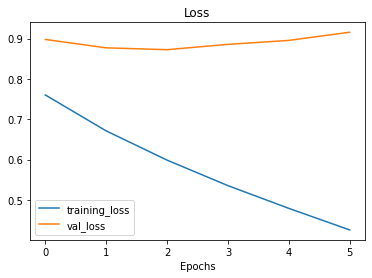

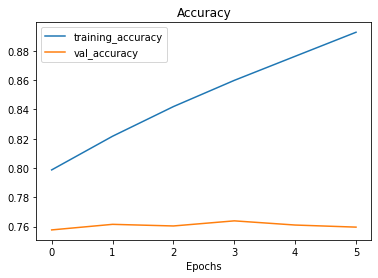

In [61]:
plot_loss_curves(history_fine_10_percent_data_aug)